In [1]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [19]:
# Annotations structure
file = './datasets/with-augmentations/Room1/Setting1/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,-1.423542,True,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,-2.282922,True,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,-3.499867,True,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,-4.512129,False,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,-4.921282,False,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [ ]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/with-augmentations/*'))+1):
    room_dir = f'./datasets/with-augmentations/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'
        for ep_dir in sorted(glob(f'{set_dir}/episode_*')):     

            ep = ep_dir.split('/')[-1]
            try:
                with open(f'{ep_dir}/{ep}.pkl', 'rb') as f:
                    df = pickle.load(f)
                    df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                    df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                    ep_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

File not found: ./datasets/with-augmentations/Room1/Setting3/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting4/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting5/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting6/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting7/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting8/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting9/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting10/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting1/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting2/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting3/episode_0010/episode_0010.pk

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [21]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/with-augmentations/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/with-augmentations/annotations.pkl')

# 2. Image Analysis

In [124]:
file = './datasets/with-augmentations/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    display(ep_dfs.head())

print(f"Number of records: {ep_dfs.shape[0]}")

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of records: 19437


In [125]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('2', '3', '0004', '00012')

In [126]:
anchor_rec

setting                                                              3
room                                                                 2
episode                                                              4
step                                                                12
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                  -1.944868
robot_pos_y                                                   0.078977
robot_yaw                                                     0.130016
robot_1_rel_pos_x                                             6.935881
robot_1_rel_pos_y                                             1.193153
robot_1_in_fov                                                    True
robot_2_rel_pos_x                                            -2.389357
robot_2_rel_pos_y                                             3.039267
robot_

In [127]:
# Look for positive examples in either other rooms or settings
pos_df = ep_dfs[(ep_dfs['room'] != anchor_rec['room']) | (ep_dfs['setting'] != anchor_rec['setting'])].copy()
pos_df

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19432,10,2,9,95,2.5,0.0,2.148549,0.440679,-0.448685,3.561599,...,-6.517727,-4.626626,False,1.312819,0.686854,True,"{'scan': [[0.11502454], [0.11180131], [0.10878...",9.0,10.0,11.0
19433,10,2,9,96,2.5,0.0,2.192943,0.418303,-0.487883,3.624322,...,-6.398505,-4.910989,False,1.228000,0.742738,True,"{'scan': [[0.113904215], [0.1104313], [0.10718...",9.0,10.0,11.0
19434,10,2,9,97,2.5,0.0,2.236652,0.394129,-0.525299,3.678385,...,-6.273469,-5.180602,False,1.143597,0.796684,True,"{'scan': [[0.11222798], [0.108507], [0.1050449...",9.0,10.0,11.0
19435,10,2,9,98,2.5,0.0,2.279233,0.368403,-0.563286,3.731676,...,-6.131744,-5.450736,False,1.060822,0.846992,True,"{'scan': [[0.109117076], [0.10516085], [0.1014...",9.0,10.0,11.0


In [128]:
# Look for negative examples in other episodes of the same setting of the room
neg_df = ep_dfs[(ep_dfs['room'] == anchor_rec['room']) & (ep_dfs['setting'] == anchor_rec['setting']) & (ep_dfs['episode'] != anchor_rec['episode'])].copy()
neg_df

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
11837,3,2,1,1,2.5,0.0,-2.479893,-0.000073,-0.013804,7.188631,...,2.776518,0.797841,True,-0.232871,3.302527,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
11838,3,2,1,2,2.5,0.0,-2.451359,-0.001099,-0.062400,6.996454,...,2.699525,0.919053,True,-0.420496,3.289073,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
11839,3,2,1,3,2.5,0.0,-2.433240,-0.002288,-0.079930,6.912797,...,2.658100,0.950464,True,-0.496416,3.289384,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
11840,3,2,1,4,2.5,0.0,-2.428370,-0.002602,-0.075003,6.920458,...,2.651392,0.921658,True,-0.486608,3.298820,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
11841,3,2,1,5,2.5,0.0,-2.425722,-0.002785,-0.055812,6.978802,...,2.659450,0.854924,True,-0.428606,3.314341,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12796,3,2,9,69,2.5,0.0,0.997397,-0.069203,-0.087072,1.128723,...,3.085372,0.993027,True,-2.109881,4.971420,False,"{'scan': [[0.03689064], [0.03631557], [0.03576...",9.0,10.0,11.0
12797,3,2,9,70,2.5,0.0,1.049300,-0.073723,-0.085898,1.065855,...,3.057219,0.981681,True,-2.152058,4.952948,False,"{'scan': [[0.035919085], [0.03535749], [0.0348...",9.0,10.0,11.0
12798,3,2,9,71,2.5,0.0,1.101226,-0.078553,-0.101965,1.030460,...,3.015706,1.026956,True,-2.277069,4.899463,False,"{'scan': [[0.035059076], [0.034490064], [0.033...",9.0,10.0,11.0
12799,3,2,9,72,2.5,0.0,1.152733,-0.084353,-0.123182,1.003024,...,2.969748,1.090631,True,-2.430905,4.846943,False,"{'scan': [[0.03386134], [0.03328288], [0.03273...",9.0,10.0,11.0


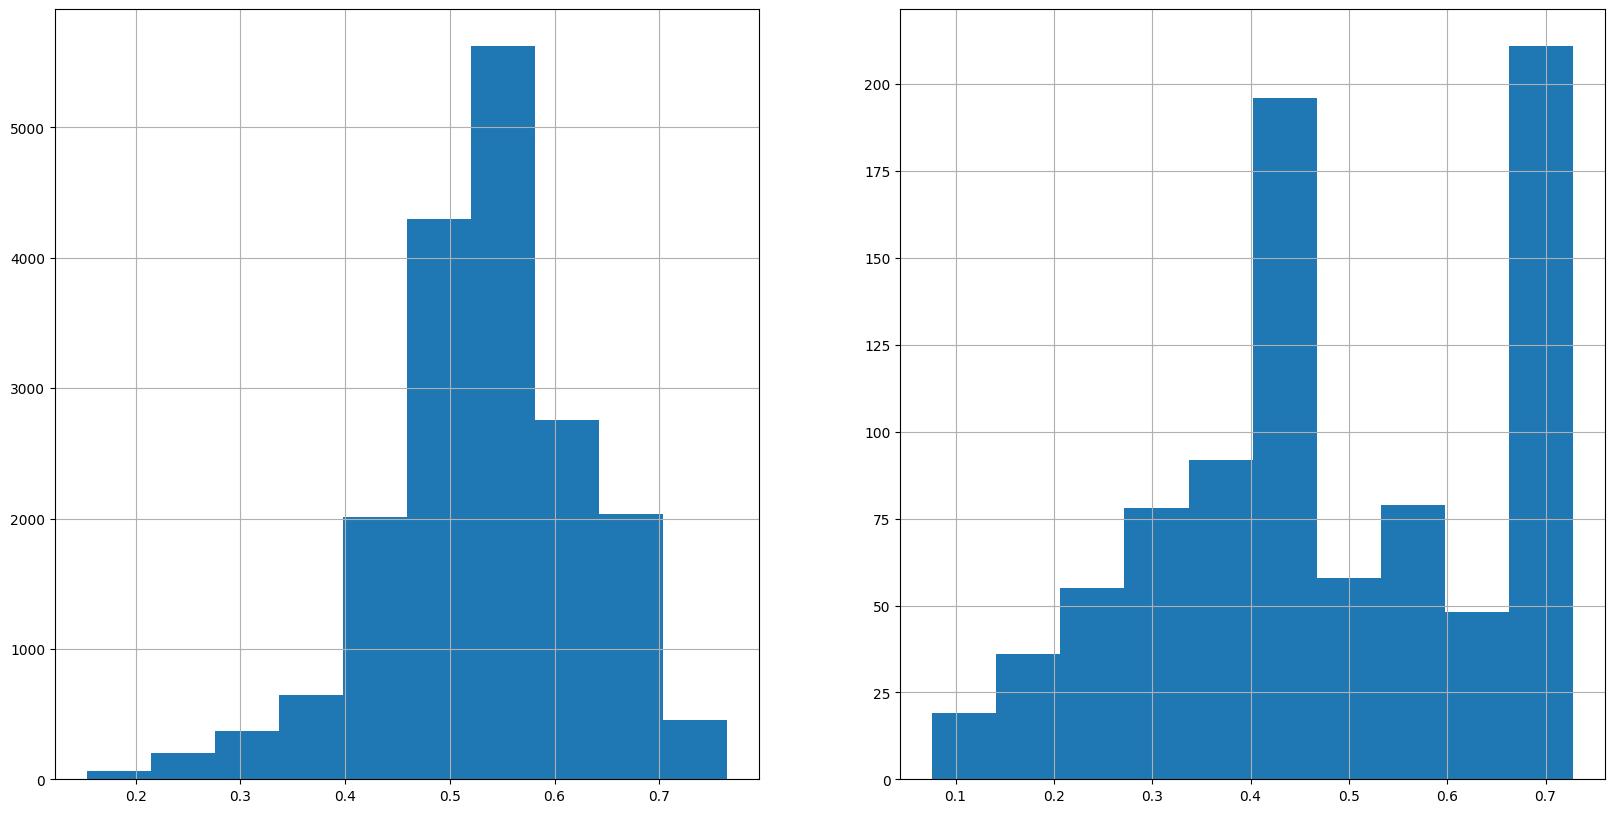

In [ ]:
# Normalized Eucledian distances on LiDAR readings 
pos_l2_dist = pos_df['laser_readings'].map(lambda x: np.sqrt(np.sum((anchor_rec.laser_readings['scan'] - x['scan'])**2))/np.sqrt(228))
neg_l2_dist = neg_df['laser_readings'].map(lambda x: np.sqrt(np.sum((anchor_rec.laser_readings['scan'] - x['scan'])**2))/np.sqrt(228))

# TODO: compute this distance considering a weight vector deoending on whether readings are in FOV or not

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_l2_dist.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_l2_dist.hist(ax=bx);

-5 -5


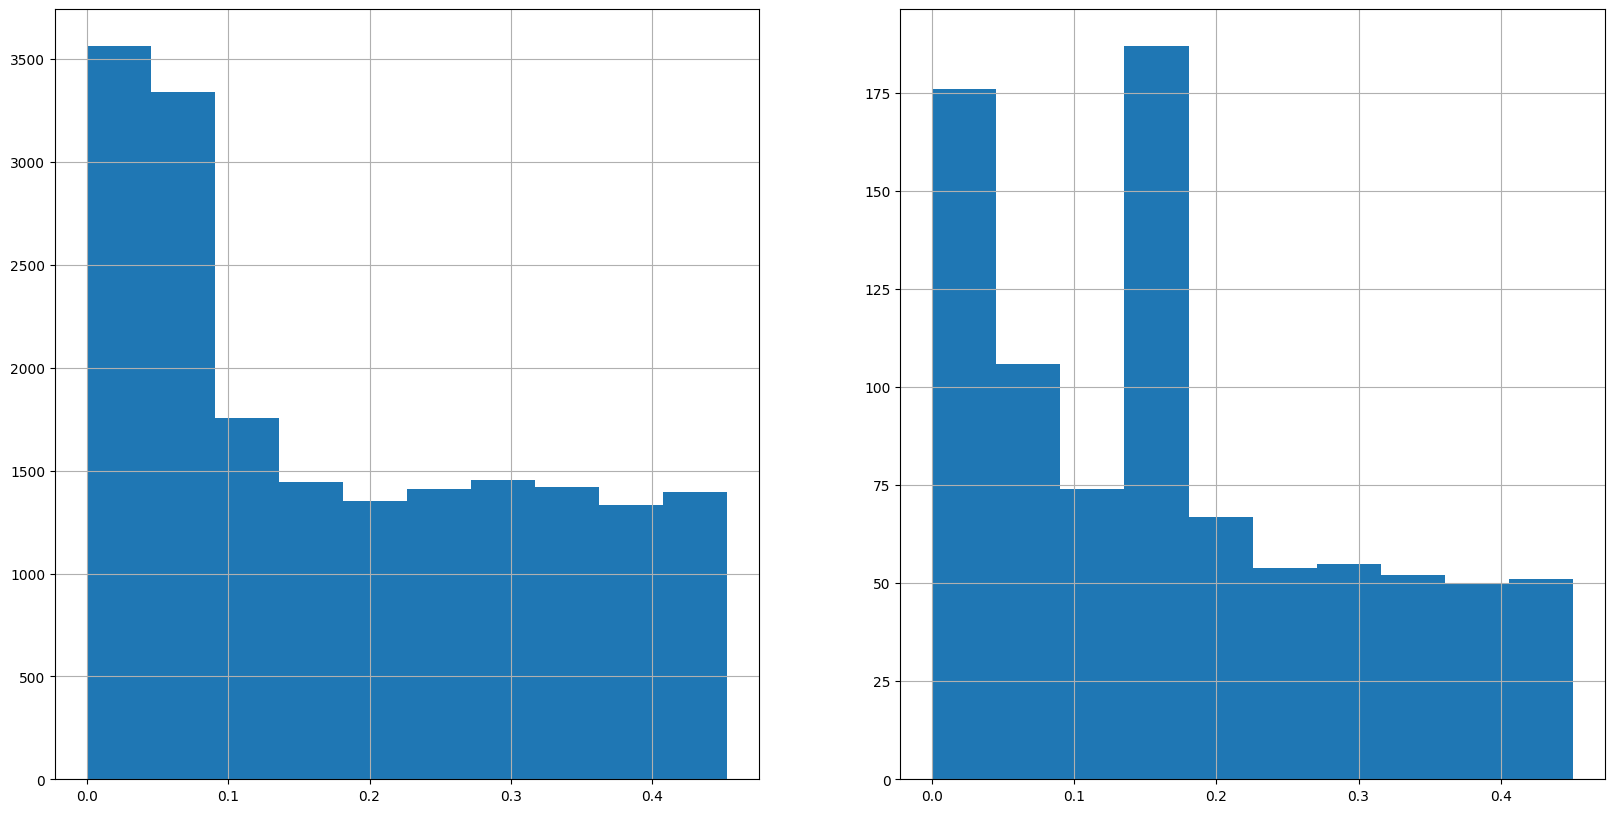

In [130]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
pos_gd_diffs = pos_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd 
neg_gd_diffs = neg_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_gd_diffs.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_gd_diffs.hist(ax=bx);

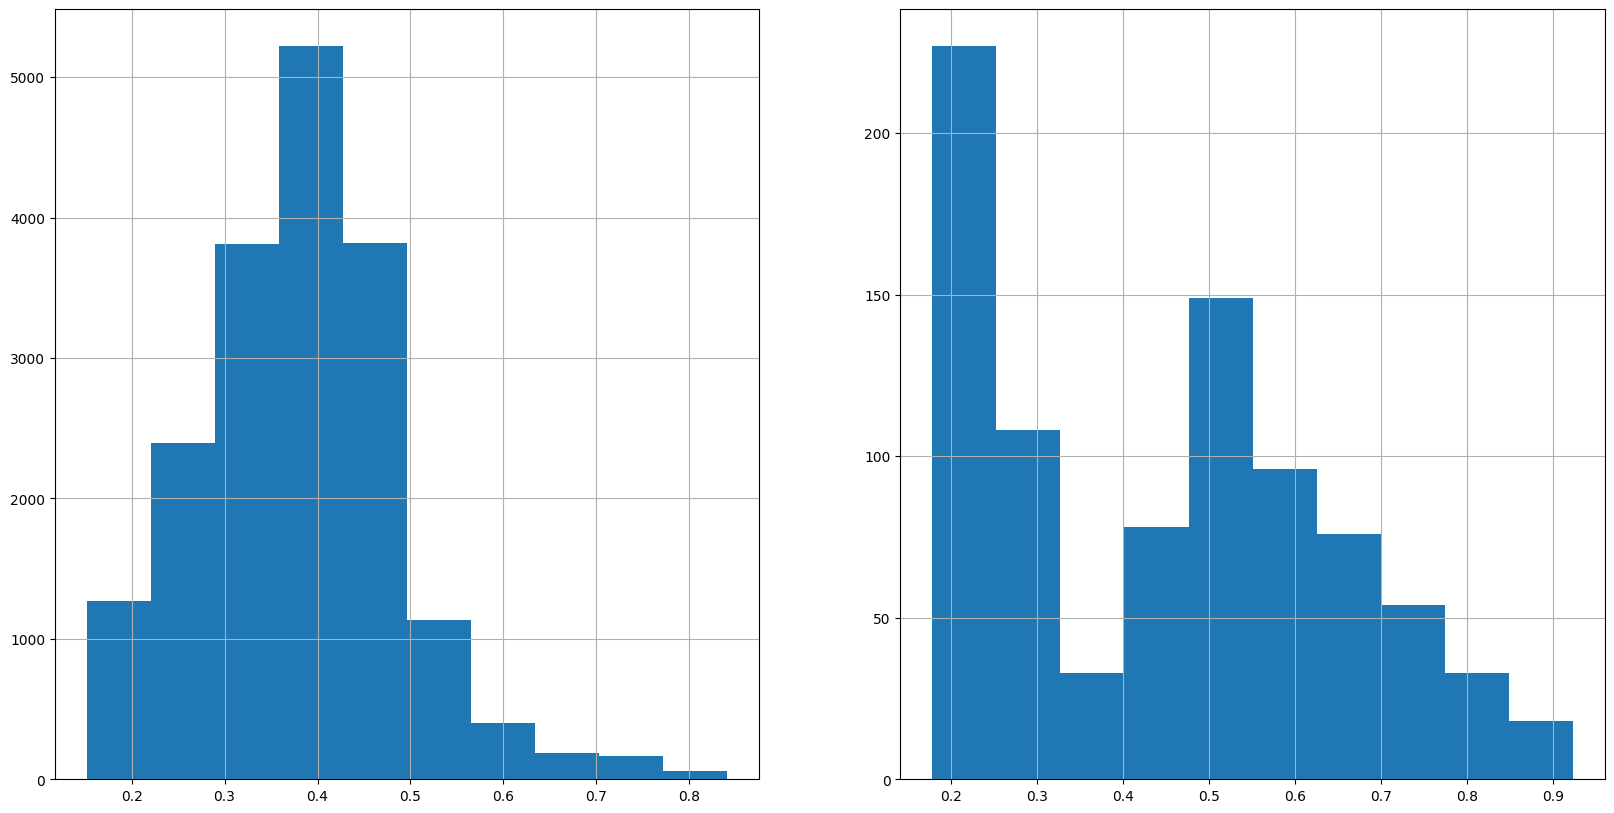

In [131]:
# Combine distances for computing similarities
pos_sim_scores = (1 - pos_l2_dist)*(1 - pos_gd_diffs)
neg_sim_scores = (1 - neg_l2_dist)*(1 - neg_gd_diffs)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_sim_scores.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_sim_scores.hist(ax=bx);

In [132]:
# Negative examples mining
BASE_NEG_DIST = 0.4
N_NEG_SAMPLES = 12

negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.05
    negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

12544    0.259377
12419    0.220666
12530    0.241237
12235    0.245877
12182    0.270612
12435    0.180360
12150    0.231899
12713    0.255625
12174    0.264345
12676    0.294882
12528    0.222295
12429    0.200054
dtype: float64

In [133]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
12544,3,2,6,90,2.5,0.0,2.105007,0.044657,-0.182760,-2.986104,...,-1.821629,-3.452742,False,-0.941697,-5.604109,False,"{'scan': [[0.17469692], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
12419,3,2,5,54,2.5,0.0,0.280886,0.006973,-0.031060,1.474562,...,-4.102737,2.154162,False,-4.221545,3.962769,False,"{'scan': [[0.05222891], [0.051550325], [0.0509...",9.0,10.0,11.0
12530,3,2,6,76,2.5,0.0,1.389715,0.136465,-0.055041,-2.582699,...,-1.707830,-3.367090,False,-0.885827,-5.281670,False,"{'scan': [[0.08083563], [0.079785615], [0.0787...",9.0,10.0,11.0
12235,3,2,3,53,2.5,0.0,0.194987,0.322269,0.072573,-2.384460,...,2.381168,-0.184730,True,2.572442,-5.058317,False,"{'scan': [[0.11400999], [0.11294751], [0.11194...",9.0,10.0,11.0
12182,3,2,2,91,2.5,0.0,2.100055,-0.024745,-0.117199,2.154470,...,-2.990173,3.448261,False,-6.467311,-4.001310,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
12435,3,2,5,70,2.5,0.0,1.114588,-0.005445,-0.025152,0.756850,...,-4.371949,2.333758,False,-4.992861,3.625173,False,"{'scan': [[0.04966573], [0.049024064], [0.0484...",9.0,10.0,11.0
12150,3,2,2,59,2.5,0.0,0.450378,0.176567,-0.115436,4.063421,...,-1.530839,3.487688,False,-5.008176,-3.758212,False,"{'scan': [[0.09211146], [0.09076675], [0.08949...",9.0,10.0,11.0
12713,3,2,8,79,2.5,0.0,1.530611,0.041647,-0.087461,-3.631142,...,-0.988612,-2.276763,False,2.193333,0.470480,True,"{'scan': [[0.06093515], [0.060058616], [0.0592...",9.0,10.0,11.0
12174,3,2,2,83,2.5,0.0,1.691084,0.024743,-0.135524,2.536906,...,-2.675728,3.379778,False,-6.047283,-4.116672,False,"{'scan': [[0.058834314], [0.05861894], [0.0603...",9.0,10.0,11.0
12676,3,2,8,42,2.5,0.0,-0.351363,0.063050,-0.043851,-1.300981,...,0.777134,-2.529517,False,3.881364,0.791216,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [134]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/with-augmentations/Room{neg_room}/Setting{neg_set}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [135]:
# Positive examples mining
BASE_POS_DIST = 0.9
N_POS_SAMPLES = 4

positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.001
    positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

15083    0.823857
15359    0.826511
15085    0.822324
15568    0.840914
dtype: float64

In [136]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
15083,6,2,3,14,2.5,0.0,-1.830424,0.113356,0.172490,0.002273,...,-1.014513,-3.087238,False,3.876917,-2.629393,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15359,6,2,6,12,2.5,0.0,-1.983945,0.078141,0.132840,3.684551,...,3.457806,-2.134918,True,6.703597,-0.661301,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15085,6,2,3,16,2.5,0.0,-1.728374,0.132588,0.196861,-0.015822,...,-1.258786,-3.044511,False,3.682120,-2.777125,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15568,6,2,8,13,2.5,0.0,-1.884790,0.090390,0.155562,0.965622,...,-1.634133,-0.530676,False,-2.102239,1.699829,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [137]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/with-augmentations/Room{pos_room}/Setting{pos_set}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

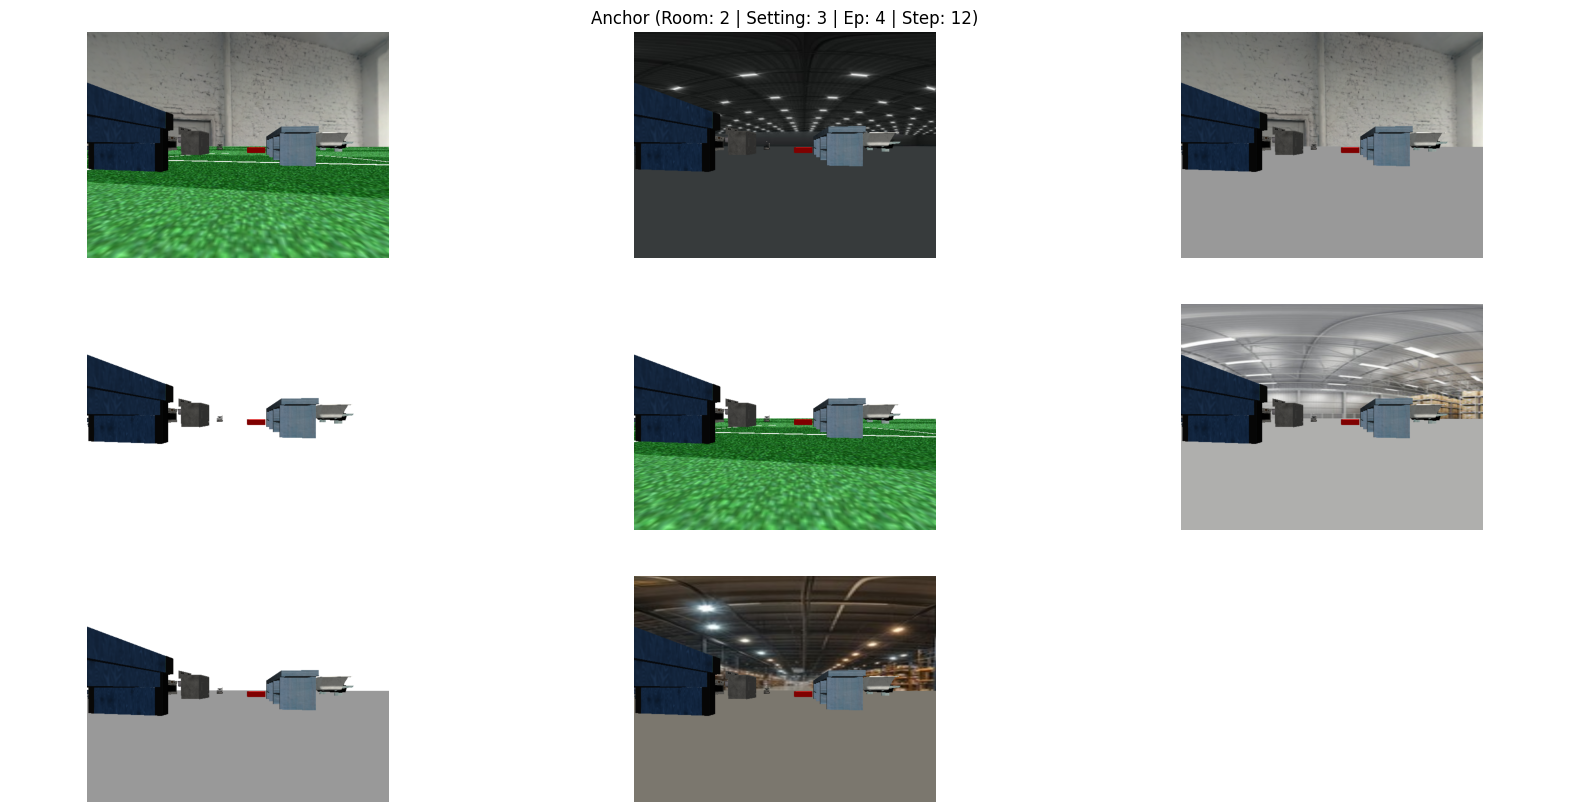

In [138]:
# Anchor image
anc_img = Image.open(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

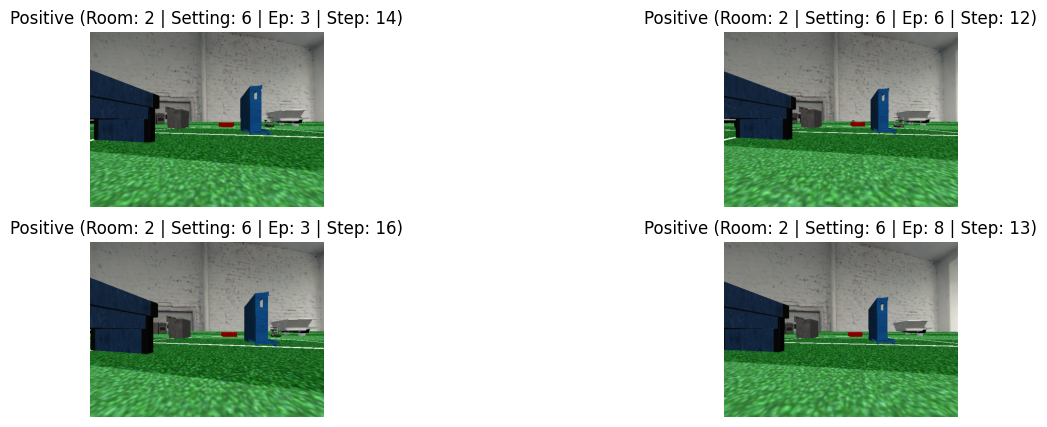

In [139]:
N_ROWS = 2
N_COLS = 2

# Plot positive examples by similarity
plt.figure(figsize=[15,5])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

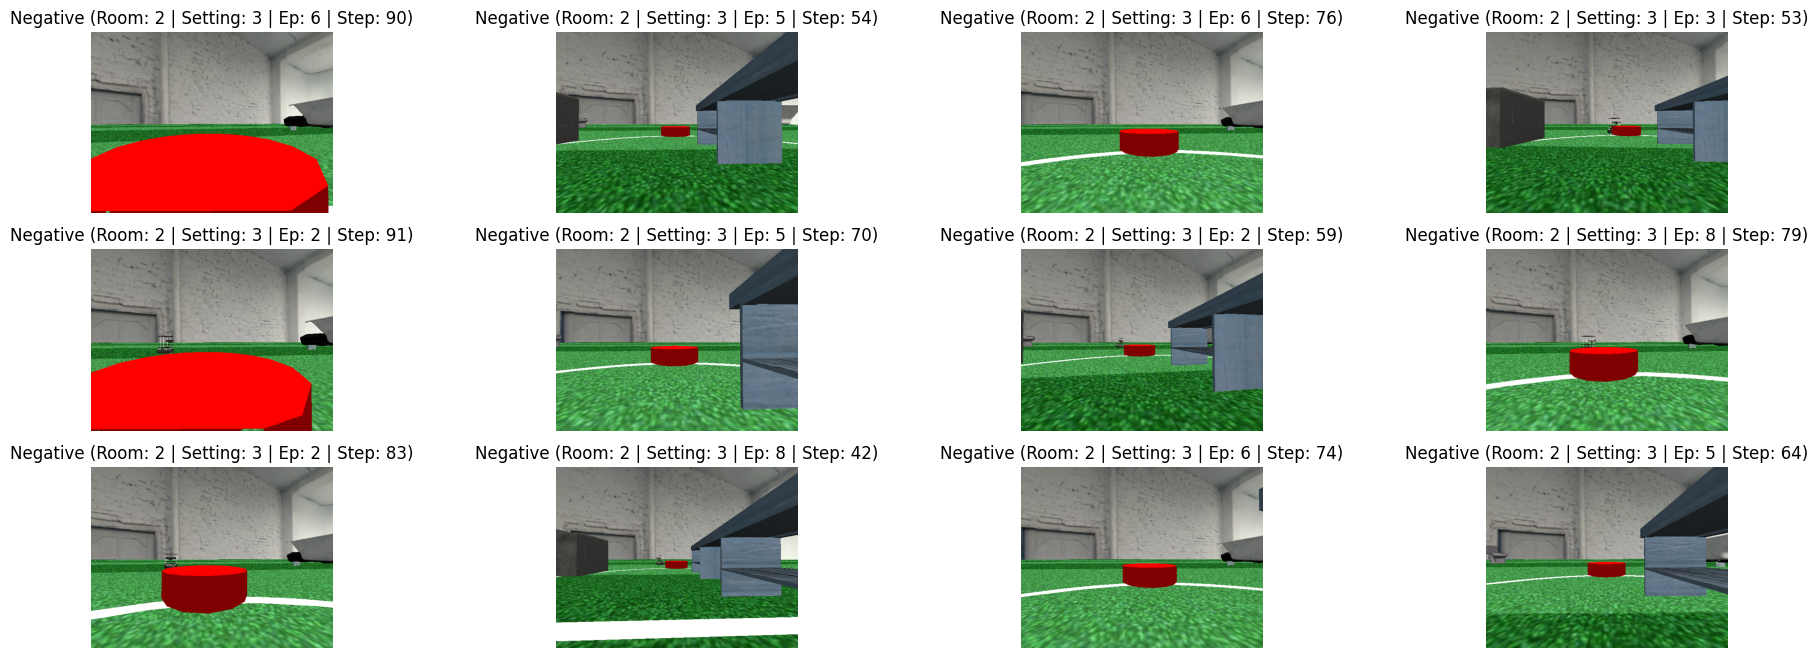

In [140]:
N_ROWS = 3
N_COLS = 4

# Plot negative examples by similarity
plt.figure(figsize=[23,8])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();